In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from pandas.plotting import autocorrelation_plot
import statsmodels.tsa.stattools as sts
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import scipy.stats
import pylab

from utils import *

In [13]:
df = pd.read_parquet("Sales_Data_v2.parquet")

In [14]:
df["TotalQty"] = df["PaidQty"] + df["FreeQty"]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8931111 entries, 0 to 8931110
Data columns (total 19 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Date               datetime64[ns]
 1   LocationId         int64         
 2   MainDistributorId  int64         
 3   DistributorId      int64         
 4   PackageId          int64         
 5   ProductId          int64         
 6   City               object        
 7   District           object        
 8   BrickId            int64         
 9   PaidQty            int64         
 10  FreeQty            int64         
 11  isPromoted         int64         
 12  Discount           float64       
 13  BeginDate          datetime64[ns]
 14  EndDate            datetime64[ns]
 15  Promo              object        
 16  DStep              float64       
 17  WeekStartDate      datetime64[ns]
 18  TotalQty           int64         
dtypes: datetime64[ns](4), float64(2), int64(10), object(3)
memory u

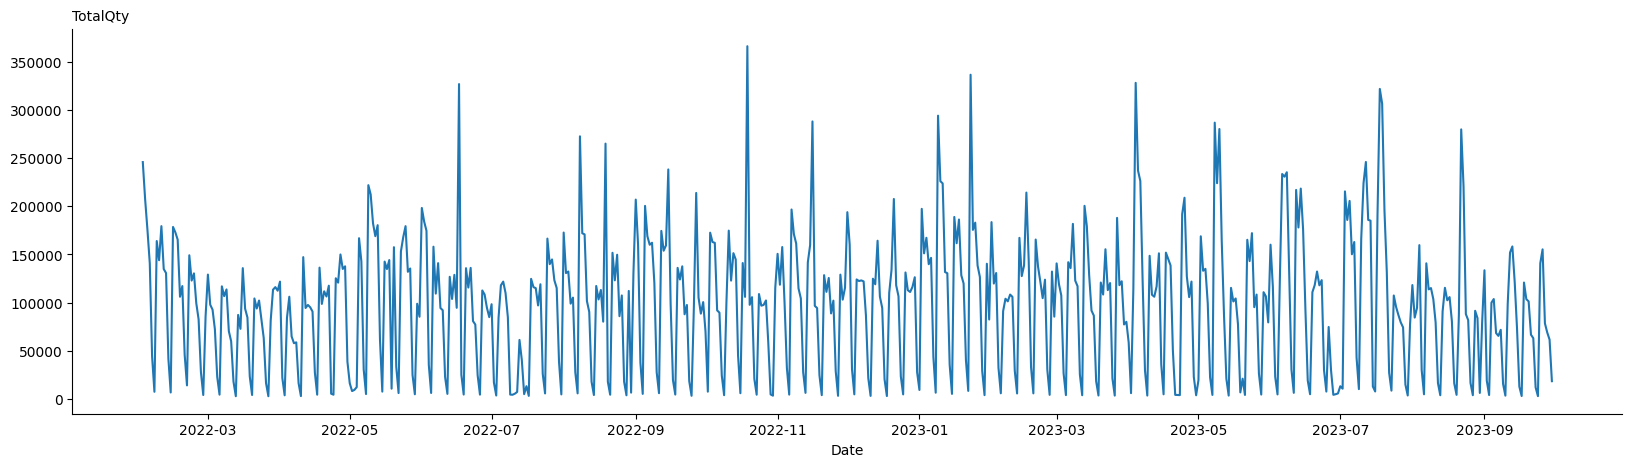

In [15]:
sales = df
sales = sales.groupby([sales['Date'].dt.date])['TotalQty'].sum()
sales.plot(figsize=(20,5), title="TotalQty")
plt.show()

In [16]:
df2 = df[["Date", "TotalQty", "PaidQty", "FreeQty", "isPromoted", "Discount", "DStep"]].set_index("Date")
# Discount: Kullanılan oran, DStep: Geçerli olan teklifin oranı

In [17]:
df2.head()

,TotalQty,PaidQty,FreeQty,isPromoted,Discount,DStep
Date,,,,,,
2023-01-02,10,10,0,0,0.0,0.0
2022-06-29,15,15,0,0,0.0,0.0
2023-01-04,3,3,0,0,0.0,0.0
2022-06-29,15,15,0,0,0.0,0.0
2023-01-04,20,20,0,0,0.0,0.0


In [18]:
fit = smf.ols('TotalQty ~ FreeQty', df2).fit()

In [19]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TotalQty   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                 1.158e+07
Date:                Mon, 11 Dec 2023   Prob (F-statistic):               0.00
Time:                        08:35:53   Log-Likelihood:            -3.2987e+07
No. Observations:             8931111   AIC:                         6.597e+07
Df Residuals:                 8931109   BIC:                         6.597e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.1531      0.003   1570.571      0.000       5.147       5.160
FreeQty        2.6839      0.001   3402.640      0.000       2.682       2.685
==============================================================================
Omnibus:                 25864001.967   Durbin-Watson:                   1.684
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   18404874264023.770
Skew:                          38.759   Prob(JB):                         0.00
Kurtosis:                    7035.228   Cond. No.                         4.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

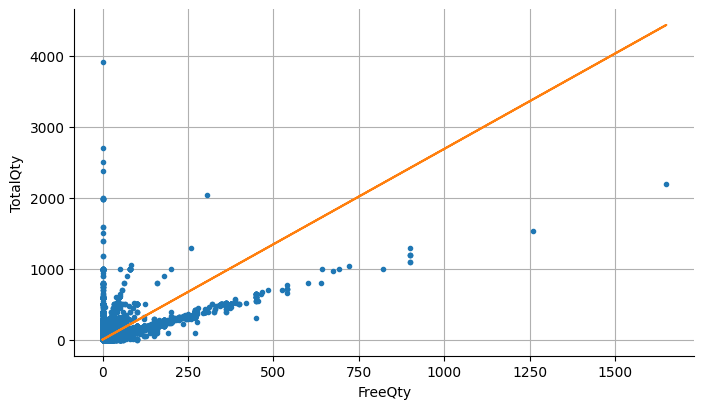

In [20]:
fig, ax = plt.subplots()
ax.plot(df2.FreeQty, df2.PaidQty, '.')
ax.plot(df2.FreeQty, fit.predict())
ax.set(ylabel="TotalQty", xlabel="FreeQty")
ax.grid()

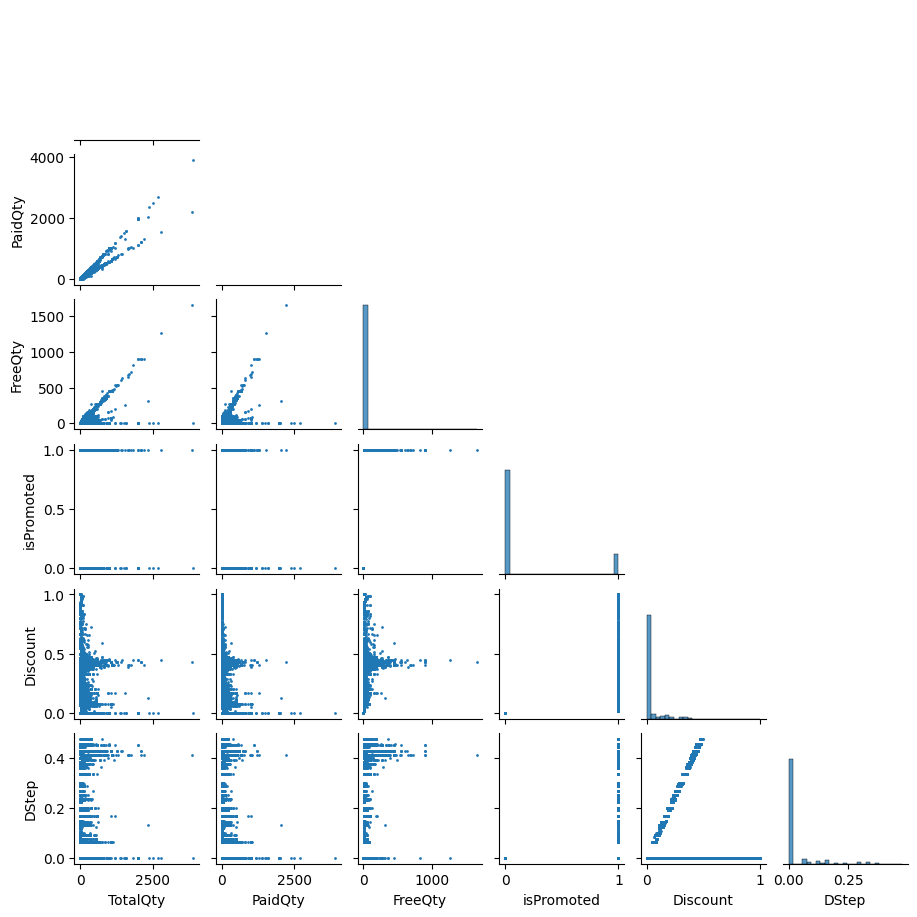

In [60]:
sns.pairplot(df2, plot_kws=dict(linewidth=0, s=4), corner=True, height=1.55);

In [22]:
fit = smf.ols('TotalQty ~ FreeQty + isPromoted + Discount', df2).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TotalQty   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                 4.783e+06
Date:                Mon, 11 Dec 2023   Prob (F-statistic):               0.00
Time:                        08:36:21   Log-Likelihood:            -3.2421e+07
No. Observations:             8931111   AIC:                         6.484e+07
Df Residuals:                 8931107   BIC:                         6.484e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3427      0.003   1300.469      0.000       4.336       4.349
FreeQty        2.7883      0.001   3395.149      0.000       2.787       2.790
isPromoted    16.4981      0.015   1098.697      0.000      16.469      16.528
Discount     -69.7688      0.077   -901.883      0.000     -69.920     -69.617
==============================================================================
Omnibus:                 27281386.926   Durbin-Watson:                   1.732
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   30288662149601.188
Skew:                          44.974   Prob(JB):                         0.00
Kurtosis:                    9024.346   Cond. No.                         107.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# All Products & Daily Aggregation

In [23]:
df3 = df.groupby([df['Date'].dt.date])[["TotalQty", "FreeQty"]].sum()
df3

,TotalQty,FreeQty
Date,,
2022-02-01,245864,22070
2022-02-02,207367,22039
2022-02-03,175478,18156
2022-02-04,140891,13635
2022-02-05,44064,3045
...,...,...
2023-09-26,155265,18971
2023-09-27,78473,6245
2023-09-28,68954,4579


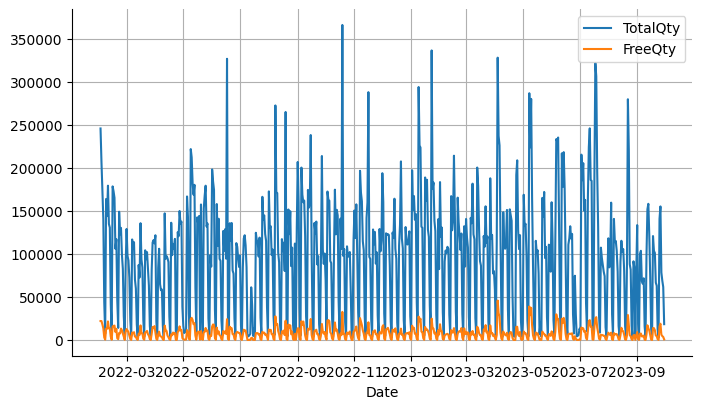

In [24]:
fig, ax = plt.subplots()
df3.plot(ax=ax)
ax.grid()

In [25]:
fit = smf.ols('TotalQty ~ FreeQty', df3).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TotalQty   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     3461.
Date:                Mon, 11 Dec 2023   Prob (F-statistic):          1.84e-252
Time:                        08:38:02   Log-Likelihood:                -7049.1
No. Observations:                 607   AIC:                         1.410e+04
Df Residuals:                     605   BIC:                         1.411e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.542e+04   1631.058     15.583      0.000    2.22e+04    2.86e+04
FreeQty        9.0900      0.155     58.828      0.000       8.787       9.393
==============================================================================
Omnibus:                       11.546   Durbin-Watson:                   1.135
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               16.270
Skew:                           0.170   Prob(JB):                     0.000293
Kurtosis:                       3.726   Cond. No.                     1.58e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.58e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

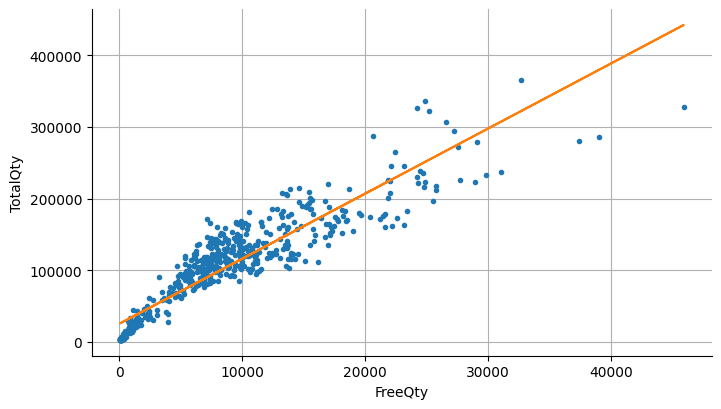

In [26]:
fig, ax = plt.subplots()
ax.plot(df3.FreeQty, df3.TotalQty, '.')
ax.plot(df3.FreeQty, fit.predict())
ax.set(ylabel="TotalQty", xlabel="FreeQty")
ax.grid()

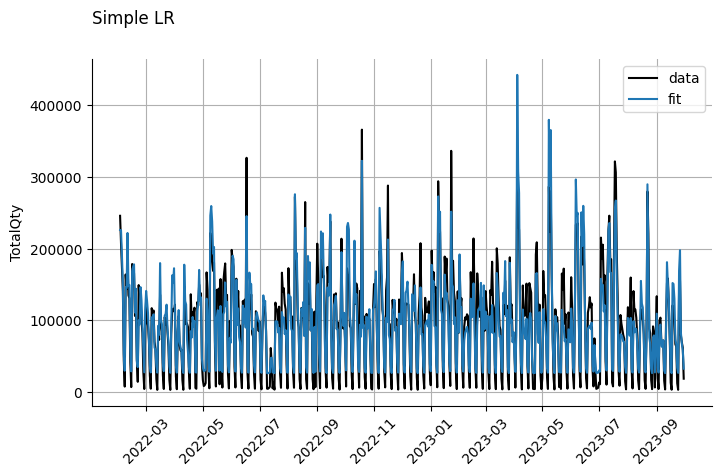

In [27]:
fig, ax = plt.subplots()
ax.plot(df3.TotalQty, label='data', color='k')
ax.plot(df3.index, fit.predict(), label='fit')
ax.set(ylabel='TotalQty')
suptitle('Simple LR')
plt.xticks(rotation=45)
ax.legend()
ax.grid()

c:\Users\ayigi\Desktop\Promo\PharmaProject\utils.py:124: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dy, bins=np.linspace(lim[0], lim[1], 22),


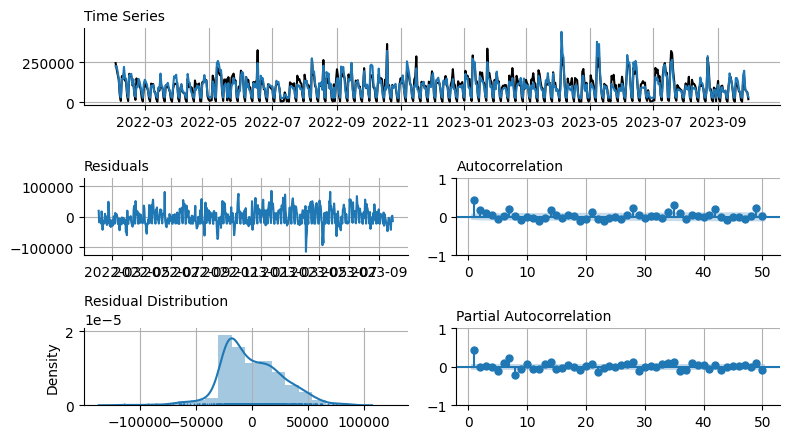

In [28]:
ypred = pd.Series(fit.predict(), index=df3.index)
plot_tsresiduals(df3.TotalQty, ypred, acf_lags=np.r_[1:51]);

In [29]:
# Model: Weekly plus linear trend.

d = df3.assign(
    weekday = df3.index.to_series().apply(lambda x: x.weekday()),
    index = np.arange(len(df3)))
d.head(7)

,TotalQty,FreeQty,weekday,index
Date,,,,
2022-02-01,245864,22070,1,0
2022-02-02,207367,22039,2,1
2022-02-03,175478,18156,3,2
2022-02-04,140891,13635,4,3
2022-02-05,44064,3045,5,4
2022-02-06,7417,465,6,5
2022-02-07,163928,13294,0,6


In [30]:
fit = smf.ols('TotalQty ~ index + weekday + FreeQty', d).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TotalQty   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     1427.
Date:                Mon, 11 Dec 2023   Prob (F-statistic):          2.21e-273
Time:                        08:38:17   Log-Likelihood:                -6992.4
No. Observations:                 607   AIC:                         1.399e+04
Df Residuals:                     603   BIC:                         1.401e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.905e+04   3560.353     13.775      0.000    4.21e+04     5.6e+04
index         16.8365      5.664      2.973      0.003       5.714      27.960
weekday    -6638.6748    621.624    -10.680      0.000   -7859.486   -5417.864
FreeQty        7.9699      0.176     45.190      0.000       7.624       8.316
==============================================================================
Omnibus:                       35.104   Durbin-Watson:                   1.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.972
Skew:                           0.382   Prob(JB):                     7.79e-15
Kurtosis:                       4.409   Cond. No.                     3.82e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.82e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

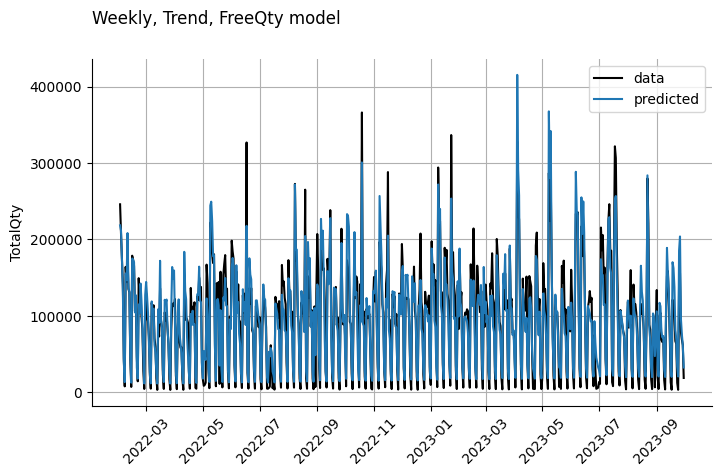

In [31]:
ypred = pd.Series(fit.predict(), index=d.index)
fig, ax = plt.subplots()
ax.plot(d.TotalQty, color='k', label='data')
ax.plot(ypred, label='predicted')
ax.legend()
ax.set(ylabel='TotalQty')
suptitle('Weekly, Trend, FreeQty model')
plt.xticks(rotation=45)
ax.grid()

c:\Users\ayigi\Desktop\Promo\PharmaProject\utils.py:124: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dy, bins=np.linspace(lim[0], lim[1], 22),


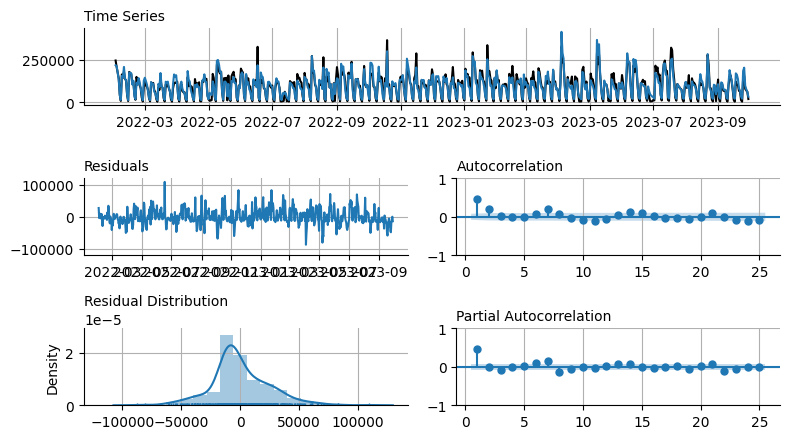

In [32]:
plot_tsresiduals(d.TotalQty, ypred);

In [33]:
dict(rsquared = fit.rsquared,
     rsquared_adj = fit.rsquared_adj,
     aic = fit.aic,
     bic = fit.bic)

{'rsquared': 0.8765544675959824,
 'rsquared_adj': 0.8759403107183505,
 'aic': 13992.819954315684,
 'bic': 14010.454069479922}

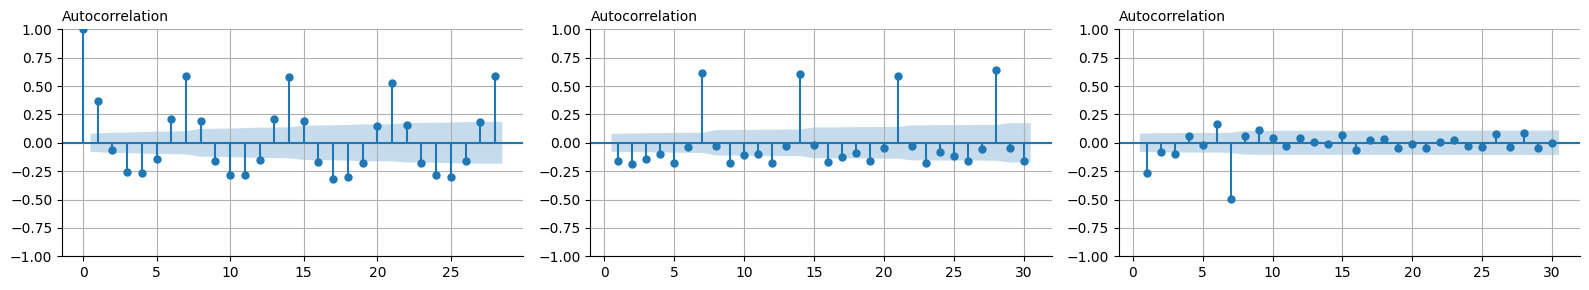

In [34]:
# ACF vs Differenced Series ACF vs Two Times Differenced log Series

fig, (a1, a2, a3) = plt.subplots(1, 3, figsize=(16,3))
d = df3
sm.graphics.tsa.plot_acf(d.TotalQty, ax=a1)
sm.graphics.tsa.plot_acf(d.TotalQty.diff().dropna(), lags=np.r_[1:31], ax=a2)
sm.graphics.tsa.plot_acf(np.log(d.TotalQty).diff().diff(7).dropna(), lags=np.r_[1:31], ax=a3)
[ax.grid() for ax in (a1,a2,a3)]
plt.tight_layout()

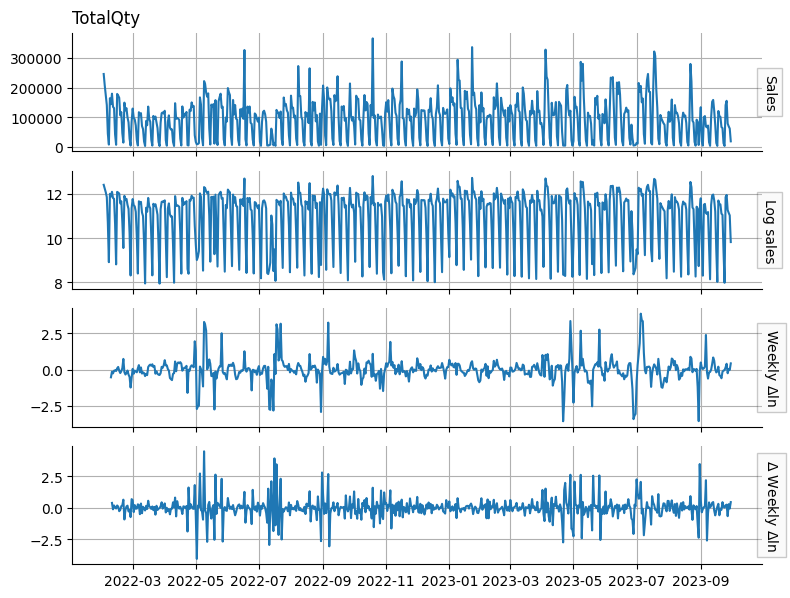

In [35]:
fig, axs = plt.subplots(4, 1, figsize=(8,6), sharex=True)
axs[0].plot(d.TotalQty)
axs[1].plot(np.log(d.TotalQty))
axs[2].plot(np.log(d.TotalQty).diff(7))
axs[3].plot(np.log(d.TotalQty).diff().diff(7))
titles = 'Sales', 'Log sales',  'Weekly $\Delta\ln$', '$\Delta$ Weekly $\Delta\ln$'
for (ax, title) in zip(axs, titles):
    rlabel(ax, title)
    ax.grid()
plt.tight_layout()
suptitle('TotalQty')
fig.subplots_adjust(top=.95)

## Unit Root Test

In [36]:
# Unit Root Test

sm.tsa.stattools.kpss(d.TotalQty, nlags='auto')

C:\Users\ayigi\AppData\Local\Temp\ipykernel_4780\617129642.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  sm.tsa.stattools.kpss(d.TotalQty, nlags='auto')


(0.16105926356180936,
 0.1,
 30,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [37]:
sm.tsa.stattools.kpss(np.log(d.TotalQty).diff(7).dropna(), nlags='auto')

C:\Users\ayigi\AppData\Local\Temp\ipykernel_4780\1081958709.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  sm.tsa.stattools.kpss(np.log(d.TotalQty).diff(7).dropna(), nlags='auto')


(0.013543769412969964,
 0.1,
 9,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [38]:
sm.tsa.stattools.kpss(np.log(d.TotalQty).dropna(), nlags='auto')

(0.47914633251466127,
 0.04636343862282404,
 550,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

## Forecasting for Each Product

In [59]:
products = [14,  16,  20,  21,  29,  30,  32,  38,  39,  41,  49, 138, 148]
df_prod = df
df_prod = df_prod.groupby([df_prod['Date'].dt.date, df_prod["ProductId"]])[["TotalQty", "FreeQty"]].sum()

df_prod = df_prod.reset_index()

df_prod = df_prod.assign(
    weekday = df_prod.Date.apply(lambda x: x.weekday()),
    index = np.arange(len(df_prod)))

rows = []

for p in products:
    d = df_prod[df_prod.ProductId == p]
    fit = smf.ols('TotalQty ~ FreeQty + weekday', d).fit()
    rows.append([fit.rsquared, fit.rsquared_adj, fit.aic,
                 fit.params["Intercept"], fit.pvalues["Intercept"], 
                 fit.params["FreeQty"], fit.pvalues["FreeQty"],
                 fit.params["weekday"], fit.pvalues["weekday"]])

results = pd.DataFrame(rows, columns = ["R-Squared", "Adj R-Squared", "AIC",
                                        "Coeff. Intercept (Base Demand)", "p-value (Int.)",
                                        "Coeff. FreeQty (Promo Sens.)", "p-value (FQty.)",
                                        "Coeff weekday", "p-value (weekday)"])

results.index = products
results

,R-Squared,Adj R-Squared,AIC,Coeff. Intercept (Base Demand),p-value (Int.),Coeff. FreeQty (Promo Sens.),p-value (FQty.),Coeff weekday,p-value (weekday)
14,0.967991,0.967885,8139.451061,387.846206,5.205601e-45,4.149975,0.000000e+00,-54.004997,5.424415e-25
16,0.955913,0.955767,8728.409881,704.268239,7.902759e-52,4.323501,0.000000e+00,-97.249367,1.107343e-28
20,0.872931,0.872510,10960.866664,4823.269138,1.871996e-64,13.017762,1.283211e-186,-652.980204,1.733792e-33
21,0.871096,0.870670,10734.029473,4674.991995,4.277191e-100,8.444269,7.815164e-195,-637.128799,5.450011e-49
29,0.640147,0.638956,11755.985868,10308.025059,3.530332e-150,9.981990,1.944081e-97,-1349.794724,4.586123e-53
30,0.990379,0.990348,9455.255799,1710.045833,5.406102e-113,2.558875,0.000000e+00,-227.825626,4.207299e-52
32,0.984826,0.984776,8266.303962,480.770302,3.702274e-43,7.140992,0.000000e+00,-64.140075,4.744164e-25
38,0.983427,0.983372,9520.980227,1307.931697,3.132066e-46,2.605583,0.000000e+00,-183.343095,4.222471e-27
39,0.998412,0.998407,10005.507616,2031.454656,9.081067e-111,13.447696,0.000000e+00,-275.196670,8.848318e-41
41,0.982267,0.982209,8481.826159,452.497869,7.861409e-59,2.799576,0.000000e+00,-64.305357,3.019706e-26
